In [62]:
from torch.utils.data import Subset, Dataset
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Subset
import torch
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn

from PIL import Image

import numpy as np
import random

import matplotlib.pyplot as plt

import csv
from sklearn import svm

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

from sklearn.linear_model import LinearRegression

import sklearn
from sklearn import datasets

from torchvision.utils import save_image, make_grid
import matplotlib.pyplot as plt

import os

from sklearn.datasets import load_digits
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

import matplotlib.colors as mcolors

## 1. Load Data, Trained Models, and Produce Features

In [23]:
subject = np.load('../run_experiments_ssl_signal/subject.npy')
label = np.load('../run_experiments_ssl_signal/label.npy')
new_label = np.load('../run_experiments_ssl_signal/new_label.npy')
eeg_data = np.load('../run_experiments_ssl_signal/eeg_data.npy')
emg_data = np.load('../run_experiments_ssl_signal/emg_data.npy')

subject = torch.from_numpy(subject).long()
label = torch.from_numpy(label).long()
new_label = torch.from_numpy(new_label).long()
eeg_data = torch.from_numpy(eeg_data).float()
emg_data = torch.from_numpy(emg_data).float()

SAMPLE_X = eeg_data
SAMPLE_Y = emg_data
label_tensor = new_label

indices = np.arange(SAMPLE_X.shape[0])

from sklearn.model_selection import train_test_split
train_X, test_X, train_labels, test_labels, idx_train, idx_test = train_test_split(SAMPLE_X, label_tensor, indices, test_size=0.2, random_state=42)

train_major_label, test_major_label = new_label[idx_train], new_label[idx_test]
train_subtle_label, test_subtle_label = label[idx_train], label[idx_test]
train_subj_label, test_subj_label = subject[idx_train], subject[idx_test]

# Define network for temporal network: 
class NETWORK_F_MLP(nn.Module):
    def __init__(self, input_dim = 784, HIDDEN = 200, out_dim = 200, how_many_layers = 2):
        super(NETWORK_F_MLP, self).__init__()
        self.dim = out_dim
        self.many_layer = how_many_layers
        
        self.fc_list = []
        self.bn_list = []
        
        self.fc_list.append(nn.Linear(input_dim, HIDDEN, bias=True))
        self.bn_list.append(nn.BatchNorm1d(HIDDEN))

        for i in range(0, self.many_layer-1):
            self.fc_list.append(nn.Linear(HIDDEN, HIDDEN, bias=True))
            self.bn_list.append(nn.BatchNorm1d(HIDDEN))
            
        self.fc_list = nn.ModuleList(self.fc_list)
        self.bn_list = nn.ModuleList(self.bn_list)

        self.fc_final = nn.Linear(HIDDEN, out_dim, bias=True)

    def forward(self, x):
        
        x = x.reshape(x.shape[0], -1)
        
        for i in range(0, self.many_layer):
            x = self.fc_list[i](x)
            x = torch.relu(x)
            x = self.bn_list[i](x)
        
        x = self.fc_final(x)
        x = torch.sigmoid(x)
        return x


# Define network for channel network: 
class Advanced1DCNN_channel(nn.Module):
    def __init__(self, input_channel=1, num_classes=100, input_size=4000, num_channel=60):
        super(Advanced1DCNN_channel, self).__init__()
        
        self.conv1 = nn.Sequential(
            nn.Conv1d(1, 32, kernel_size=11, padding=5),
            nn.BatchNorm1d(32),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=4, stride=4)
        )
        
        self.conv2 = nn.Sequential(
            nn.Conv1d(32, 64, kernel_size=11, padding=5),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=4, stride=4)
        )

        self.conv3 = nn.Sequential(
            nn.Conv1d(64, 128, kernel_size=11, padding=5),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=4, stride=4)
        )

        self.conv4 = nn.Sequential(
            nn.Conv1d(128, 256, kernel_size=11, padding=5),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=4, stride=4)
        )

        self.fc1 = nn.Sequential(
            nn.Linear(256 * 15, 1024),
            nn.BatchNorm1d(1024),
            nn.ReLU(),
        )

        self.fc2 = nn.Sequential(
            nn.Linear(1024, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
        )

        self.fc3 = nn.Linear(512, num_classes)
        
        self.MLP = NETWORK_F_MLP(input_dim = 128*input_channel, HIDDEN = 4000, out_dim = num_classes, how_many_layers = 1)
        
    def forward(self, x):
        bs, channel = x.shape[0], x.shape[1]
        x = x.unsqueeze(2)
        x = x.flatten(0, 1)
        out = self.conv1(x)
        out = self.conv2(out)
        out = self.conv3(out)
        out = self.conv4(out)
        out = out.view(out.size(0), -1)
        out = self.fc1(out)
        out = self.fc2(out)
        out = self.fc3(out)
        out = torch.sigmoid(out)
        out = out.reshape(bs, channel, -1)
        out = out.flatten(-2, -1)
        out = self.MLP(out)
        return out

def custom_forward_sequential_different_cnn(loaded_model, x):
        
    bs, channel = x.shape[0], x.shape[1]
    x = x.unsqueeze(2)
    x = x.flatten(0, 1)
        
    input_list = []
    output_list = []
    
    model = loaded_model  # assuming that the VGG backbone is saved in 'features' attribute
    model_sequence = list(model.children())
            
    for sequence in model_sequence[:4]:
        for layer in sequence:
            if isinstance(layer, nn.Conv1d):
                input_list.append(x)
                x = layer(x)
            elif isinstance(layer, nn.BatchNorm1d):
                x = layer(x)
            elif isinstance(layer, nn.ReLU):
                x = layer(x)
                output_list.append(x)
            elif isinstance(layer, nn.MaxPool1d):
                input_list.append(x)
                x = layer(x)
                output_list.append(x)

    input_list.append(x)
    x = x.view(x.size(0), -1)
    x = model_sequence[4](x)
    x = model_sequence[5](x)
    x = model_sequence[6](x)
    x = torch.sigmoid(x)
    output_list.append(x.unsqueeze(2))

    x = x.reshape(bs, channel, -1)
    input_list.append(x.permute(0, 2, 1))
    x = x.flatten(-2, -1)
    x = model_sequence[-1](x)
    output_list.append(x.unsqueeze(-1))

    return x, input_list, output_list

SAMPLE_X = eeg_data
SAMPLE_Y = emg_data

label_tensor = new_label
indices = np.arange(SAMPLE_X.shape[0])

from sklearn.model_selection import train_test_split
train_X, test_X, train_labels, test_labels, idx_train, idx_test = train_test_split(torch.cat((SAMPLE_X, SAMPLE_Y), 1), label_tensor, indices, test_size=0.2, random_state=42)
train_X, train_Y, test_X, test_Y = train_X[:, :60], train_X[:, 60:], test_X[:, :60], test_X[:, 60:]

NET_1 = Advanced1DCNN_channel(SAMPLE_X.shape[1], 128, 4000).cuda()
NET_2 = Advanced1DCNN_channel(SAMPLE_Y.shape[1], 128, 4000).cuda()

device = torch.device("cuda:2")

# NET_1.load_state_dict(torch.load('./save_exp_inter_subj/NET_1_iter30000.pth', map_location=device))
# NET_2.load_state_dict(torch.load('./save_exp_inter_subj/NET_2_iter30000.pth', map_location=device))

NET_1.load_state_dict(torch.load('../experiment_dependence_main/NET_1_iter10000.pth', map_location=device))
NET_2.load_state_dict(torch.load('../experiment_dependence_main/NET_2_iter10000.pth', map_location=device))

NET_1.eval()
NET_2.eval()

save_train_features = torch.zeros((train_X.shape[0], 128))
with torch.no_grad():
    for index, samples_index in enumerate(range(0, train_X.shape[0], 10)):
        input_x = train_X[samples_index:samples_index+10]
        x, input_list, output_list = custom_forward_sequential_different_cnn(NET_1, input_x.cuda())
        save_train_features[samples_index:samples_index+10] = x.detach().cpu()
        
save_test_features = torch.zeros((test_X.shape[0], 128))
with torch.no_grad():
    for index, samples_index in enumerate(range(0, test_X.shape[0], 10)):
        input_x = test_X[samples_index:samples_index+10]
        x, input_list, output_list = custom_forward_sequential_different_cnn(NET_1, input_x.cuda())
        save_test_features[samples_index:samples_index+10] = x.detach().cpu()
        
save_train_features_emg = torch.zeros((train_Y.shape[0], 128))
with torch.no_grad():
    for index, samples_index in enumerate(range(0, train_Y.shape[0], 10)):
        input_x = train_Y[samples_index:samples_index+10]
        x, input_list, output_list = custom_forward_sequential_different_cnn(NET_2, input_x.cuda())
        save_train_features_emg[samples_index:samples_index+10] = x.detach().cpu()

save_test_features_emg = torch.zeros((test_Y.shape[0], 128))
with torch.no_grad():
    for index, samples_index in enumerate(range(0, test_Y.shape[0], 10)):
        input_x = test_Y[samples_index:samples_index+10]
        x, input_list, output_list = custom_forward_sequential_different_cnn(NET_2, input_x.cuda())
        save_test_features_emg[samples_index:samples_index+10] = x.detach().cpu()

## 2. Produce Projection Figures (Show Clusters)

/home/UFAD/hubo/anaconda3/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,


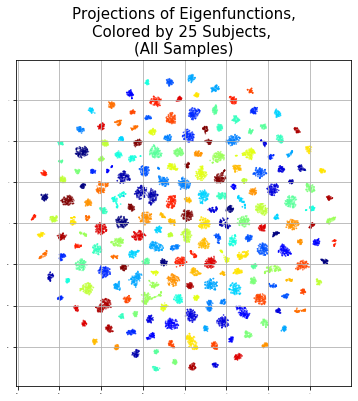

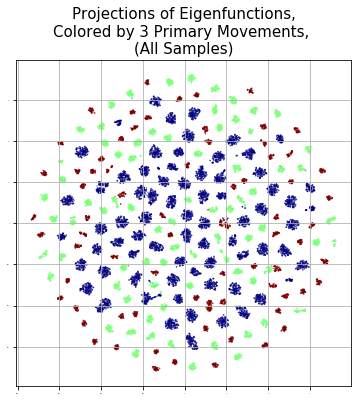

In [51]:
# We first apply TSNE to all samples

tsne = TSNE(n_components=2, perplexity=10, learning_rate=200, random_state=42)
X_embedded = tsne.fit_transform(save_train_features[:, :])

import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

plt.figure(figsize=(6, 6))
plt.scatter(X_embedded[:, 0], X_embedded[:, 1], marker='o', alpha=0.5, c=train_subj_label, s=.3, cmap='jet')
plt.grid('None')
plt.tick_params(axis='both', which='major', labelsize=0)
plt.title('Projections of Eigenfunctions,\nColored by 25 Subjects, \n(All Samples)', fontsize=15)
plt.show()

plt.figure(figsize=(6, 6))
plt.scatter(X_embedded[:, 0], X_embedded[:, 1], marker='o', alpha=0.5, c=train_labels, s=.3, cmap='jet')
plt.grid('None')
plt.tick_params(axis='both', which='major', labelsize=0)
plt.title('Projections of Eigenfunctions,\nColored by 3 Primary Movements, \n(All Samples)', fontsize=15)
plt.show()

In [63]:
# Now we show t-SNE of each subject and each primary movement and each 

index_subj = [np.where(train_subj_label==k)[0] for k in range(0, 5)]

for subject_index in range(0, 5):
    # pick five different subjects
    tsne = TSNE(n_components=2, perplexity=10, learning_rate=200, random_state=42)
    X_embedded = tsne.fit_transform(save_train_features[index_subj[subject_index]])
    
    np.save('X_embedded_tsne_{0}.npy'.format(subject_index), X_embedded)
    
save_index = []

for k in range(0, train_major_label.shape[0]):
    if train_major_label[k] == 0 and train_subj_label[k] in [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]:
        save_index.append(k)

tsne = TSNE(n_components=2, perplexity=10, learning_rate=200, random_state=42)
X_embedded = tsne.fit_transform(save_train_features[save_index])
np.save('ten_subjects.npy', X_embedded)

/home/UFAD/hubo/anaconda3/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/home/UFAD/hubo/anaconda3/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/home/UFAD/hubo/anaconda3/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/home/UFAD/hubo/anaconda3/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/home/UFAD/hubo/anaconda3/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/home/UFAD/hubo/anac

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


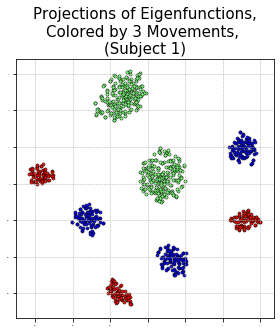

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


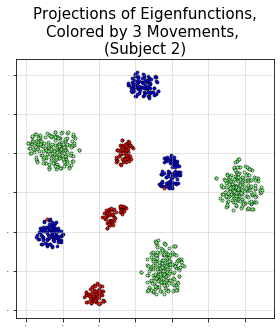

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


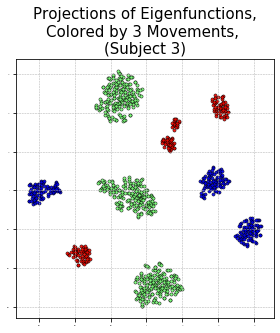

In [99]:
# Visualize Projections of Subjects

dot_point = [np.load('X_embedded_tsne_{0}.npy'.format(k)) for k in [0, 2, 3]]
dot_point.append(np.load('ten_subjects.npy'))
dot_labels = [train_labels[index_subj[k]] for k in [0, 2, 3]]
dot_labels.append(train_subj_label[save_index])

for k, X_embedded in enumerate(dot_point[:3]):
    fig = plt.figure(figsize=(4, 4))
    X_embedded_0 = X_embedded[dot_labels[k] == 0]
    X_embedded_1 = X_embedded[dot_labels[k] == 1]
    X_embedded_2 = X_embedded[dot_labels[k] == 2]

    # Create a colormap and a normalization
    cmap = plt.cm.jet
    norm = mcolors.Normalize(vmin=0, vmax=10)
    
    # Plot each group of data points with their respective label
    plt.scatter(X_embedded_0[:, 0], X_embedded_0[:, 1], marker='o', alpha=.9, label='twist', c=cmap(norm(5)), s=10, edgecolors='k', linewidths=0.5)
    plt.scatter(X_embedded_1[:, 0], X_embedded_1[:, 1], marker='o', alpha=.9, label='multi-grasp', c=cmap(norm(1)), s=10, edgecolors='k', linewidths=0.5)
    plt.scatter(X_embedded_2[:, 0], X_embedded_2[:, 1], marker='o', alpha=.9, label='reaching', c=cmap(norm(9)), s=10, edgecolors='k', linewidths=0.5)
    plt.grid('None', which='both', linestyle='--', linewidth=.5, zorder=-999)
    plt.tick_params(axis='both', which='major', labelsize=0)
    plt.tight_layout()

    plt.title('Projections of Eigenfunctions,\nColored by 3 Movements, \n(Subject {0})'.format(k+1), fontsize=15)
    
    plt.savefig('try_this_style_{0}.png'.format(k+1), dpi=500, bbox_inches='tight', pad_inches=0.1)
    plt.show()

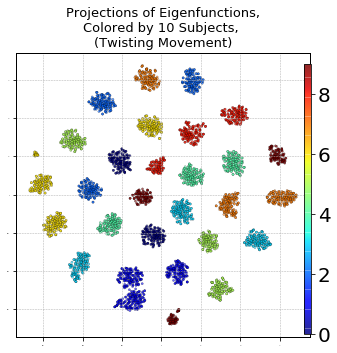

In [100]:
# Visualize Projections of Cetain Movement

save_index = []

for k in range(0, train_major_label.shape[0]):
    if train_major_label[k] == 0 and train_subj_label[k] in [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]:
        save_index.append(k)

fig = plt.figure(figsize=(4.5, 5))

k = 3
ax_scatter = plt.gca()

X_embedded = dot_point[3]
sc = plt.scatter(X_embedded[:, 0], X_embedded[:, 1], marker='o', alpha=.6, label='twist', c=train_subj_label[save_index], s=5, edgecolors='k', linewidths=0.3, cmap='jet')# X_embedded_0 = X_embedded[dot_labels[k] == 0]
plt.grid('None', which='both', linestyle='--', linewidth=.5, zorder=-999)
plt.tick_params(axis='both', which='major', labelsize=0)
plt.title('Projections of Eigenfunctions,\nColored by 10 Subjects, \n(Twisting Movement)'.format(k), fontsize=13)

plt.tight_layout()
# plt.title('Motion "twist" from 10 patients',fontsize=25)

# plt.colorbar()
# ax = plt.gca()
# for spine in ax.spines.values():
#     spine.set_visible(False)
ax_cbar = fig.add_axes([.95, 0.06, 0.02, 0.75])  # Syntax: add_axes([left, bottom, width, height])
cbar = plt.colorbar(sc, cax=ax_cbar)
cbar.ax.tick_params(labelsize=20)

for spine in ax_scatter.spines.values():
    spine.set_linewidth(1)  
    
plt.show()

## 3. Show Density Ratios

In [101]:
# First, We Calculate the Density Ratios

# Calculate Density Ratios with Trained Features, through two-step normalizations

RF = save_train_features.T@save_train_features/save_train_features.shape[0]
RG = save_train_features_emg.T@save_train_features_emg/save_train_features_emg.shape[0]
P = save_train_features.T@save_train_features_emg/save_train_features.shape[0]

input_dim, output_dim = RF.shape[1], RG.shape[1]
RFG = torch.zeros((input_dim+output_dim, input_dim+output_dim))
RFG[:input_dim, :input_dim] = RF
RFG[input_dim:, input_dim:] = RG
RFG[:input_dim, input_dim:] = P
RFG[input_dim:, :input_dim] = P.T

# Making features orthonormal
E1,V1 = torch.linalg.eigh(RFG[:128, :128])
E2,V2 = torch.linalg.eigh(RFG[128:, 128:])

RF_NORM = V1@torch.diag(E1**(-1/2))@V1.T
RG_NORM = V2@torch.diag(E2**(-1/2))@V2.T

# Making features equilibrium
P = RFG[:input_dim, input_dim:]
P_STAR = RF_NORM@P@RG_NORM    

# Calculating eigenvalues
U, S, V = torch.svd(P_STAR)

RF_NORM = RF_NORM.detach().cpu()
U = U.detach().cpu()

RG_NORM = RG_NORM.detach().cpu()
V = V.detach().cpu()

density_ratio = ((save_train_features@RF_NORM@U)*(save_train_features_emg@RG_NORM@V))*((S.detach().cpu()).view(1, -1))
density_ratio = density_ratio.sum(1)
np.save('density_ratio.npy', density_ratio)

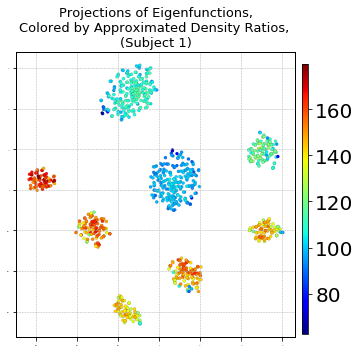

In [102]:
# Plot the density ratio values along with the t-SNE projection

ratio_value = np.load('density_ratio.npy')

fig = plt.figure(figsize=(4.5, 5))

k = 2
ax_scatter = plt.gca()

X_embedded = dot_point[0]
sc = plt.scatter(X_embedded[:, 0], X_embedded[:, 1], marker='o', alpha=1, label='twist', c=ratio_value[index_subj[0]], s=10, edgecolors='k', linewidths=0.1, cmap='jet')# X_embedded_0 = X_embedded[dot_labels[k] == 0]
plt.grid('None', which='both', linestyle='--', linewidth=.5, zorder=-999)
plt.tick_params(axis='both', which='major', labelsize=0)
plt.title('Projections of Eigenfunctions,\nColored by Approximated Density Ratios, \n(Subject 1)', fontsize=13)

plt.tight_layout()

# plt.colorbar()
# ax = plt.gca()
# for spine in ax.spines.values():
#     spine.set_visible(False)
ax_cbar = fig.add_axes([.95, 0.06, 0.02, 0.75])  # Syntax: add_axes([left, bottom, width, height])
cbar = plt.colorbar(sc, cax=ax_cbar)
cbar.ax.tick_params(labelsize=20)

for spine in ax_scatter.spines.values():
    spine.set_linewidth(1)  


plt.savefig('cmap_ratio2.png'.format(k), dpi=500, bbox_inches='tight', pad_inches=0.1)
plt.show()

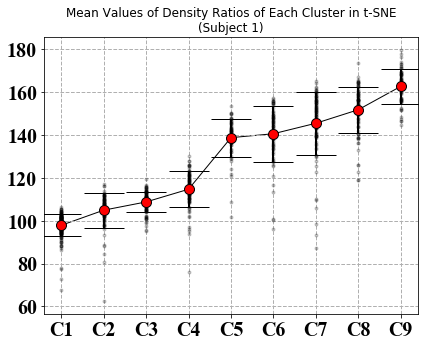

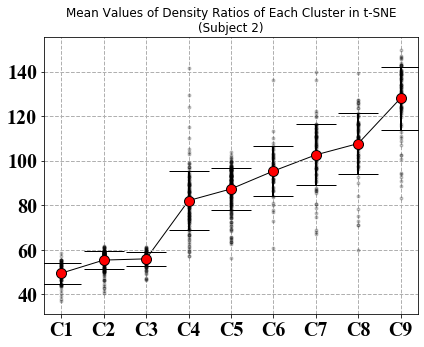

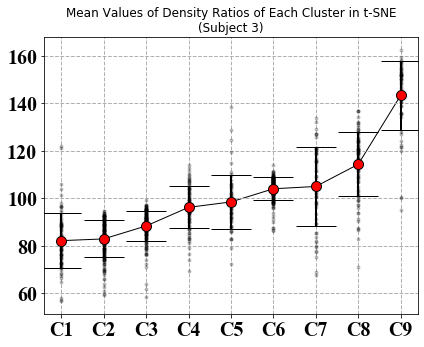

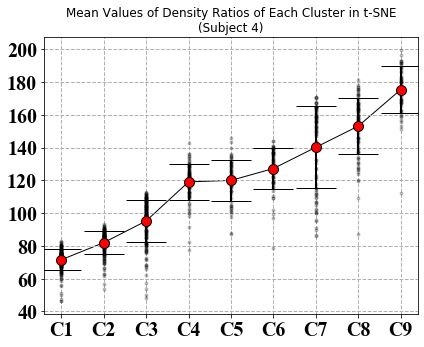

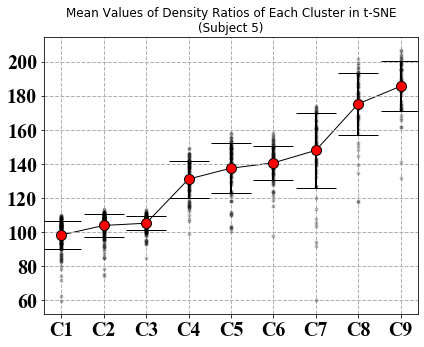

In [116]:
import numpy as np
from sklearn.datasets import load_digits
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

from sklearn.cluster import KMeans

from matplotlib.font_manager import FontProperties

def return_mean(density_ratio_fmca):
    arrays = [density_ratio_fmca[np.where(label_subj==k)[0]] for k in range(0, 9)]
    arrays = [arrays[k][~np.isnan(arrays[k])] for k in range(0, len(arrays))]

    means = [np.mean(a) for a in arrays]
    sorted_indices = np.argsort(means)
    sorted_arrays = [arrays[i] for i in sorted_indices]
    sorted_means = [sorted_arrays[k].mean() for k in range(0, len(sorted_arrays))]
    sorted_variances = [sorted_arrays[k].var() for k in range(0, len(sorted_arrays))]
    return sorted_arrays, sorted_means, sorted_variances

def to_show_lines(visual_data, k):
    sorted_arrays, sorted_means, sorted_variances = visual_data
    calibri_font = FontProperties()
    calibri_font.set_family('Times New Roman')
    calibri_font.set_size(20)
    calibri_font.set_weight('bold')
    
    plt.figure(figsize=(6, 4.5))
    x_positions = np.arange(1, len(sorted_arrays) + 1)

    # Error bars and points
    for i, data in enumerate(sorted_arrays):
        y_positions = np.full(data.shape, i + 1)  # create an array of constant value a_i for x positions
        plt.plot(y_positions, data, 'o', markersize=3, alpha=0.2, label='Data' if i == 0 else "", color='black')  # plot data points
        plt.errorbar(i + 1, sorted_means[i], yerr=np.sqrt(sorted_variances[i]), markersize=10, fmt='o', color='red', ecolor='black', elinewidth=2, capsize=20, capthick=2, markeredgewidth=1, markeredgecolor='black', label='Mean ± Std' if i == 0 else "") 

    plt.plot(np.arange(0, len(sorted_means))+1, sorted_means, '-', color='black', linewidth=1,zorder=-999,alpha=1)
    plt.xticks(ticks=x_positions, labels=['C{0}'.format(i+1) for i in range(len(sorted_arrays))],fontsize=15, fontproperties=calibri_font)
    plt.yticks(fontsize=15, fontproperties=calibri_font)
    plt.grid(True, which='both', linestyle='--', linewidth=1)
    plt.savefig("neurips_figure_{0}.png".format(k), dpi=300, bbox_inches='tight', pad_inches=0.1)  # Save as high-resolution figure
    
    plt.tight_layout()
    plt.title('Mean Values of Density Ratios of Each Cluster in t-SNE\n(Subject {0})'.format(subject_index+1),)
    plt.show()

for subject_index in range(0, 5):
    X_embedded = np.load('X_embedded_tsne_{0}.npy'.format(subject_index))
    n_clusters = 9
    kmeans = KMeans(n_clusters, random_state = 42)
    kmeans.fit(X_embedded)
    
    centroids = kmeans.cluster_centers_
    label_subj = kmeans.labels_

    density_ratio_fmca = ratio_value[index_subj[subject_index]]
    to_show_lines(return_mean(density_ratio_fmca), 1)

#     plt.figure(figsize=(10, 10))
#     sc = plt.scatter(X_embedded[:, 0], X_embedded[:, 1], marker='o', alpha=.7, c=train_labels[index_subj[subject_index]], s=50, cmap=dark_cmap, edgecolors='k', linewidths=0.7)

#     # Here is where we handle the axes' spines to remove the boundary
#     ax = plt.gca()  # Get current axes
#     for spine in ax.spines.values():
#         spine.set_visible(False)  # Hide the spines

#     plt.grid(True)  # If you want the grid lines to appear
#     plt.tick_params(axis='both', which='major', labelsize=0)  # Hides the tick labels

#     plt.show()

## 4. Additional Figures

/home/UFAD/hubo/anaconda3/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,


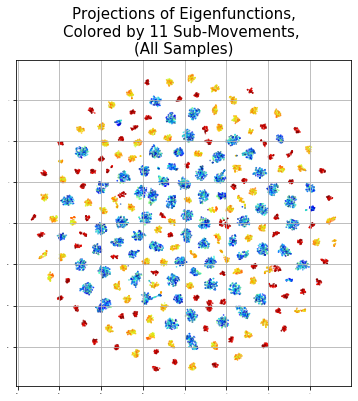

In [127]:
# Unfortuntaely the 11 sub-movements are not spanned by the eigenfunctions

# The clusters do not show clear boundaries of 11 sub-movemenets

tsne = TSNE(n_components=2, perplexity=10, learning_rate=200, random_state=42)
X_embedded = tsne.fit_transform(save_train_features[:, :])

plt.figure(figsize=(6, 6))
plt.scatter(X_embedded[:, 0], X_embedded[:, 1], marker='o', alpha=0.5, c=train_subtle_label, s=.3, cmap='jet')
plt.grid('None')
plt.tick_params(axis='both', which='major', labelsize=0)
plt.title('Projections of Eigenfunctions,\nColored by 11 Sub-Movements, \n(All Samples)', fontsize=15)
plt.show()

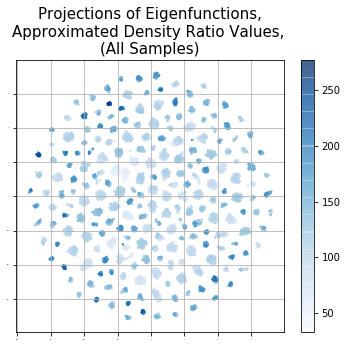

In [136]:
# Show all samples, colored by the approximated density ratio values

# It can be seen that each cluster has its own density ratio values

import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

plt.figure(figsize=(6, 5))

plt.scatter(X_embedded[:, 0], X_embedded[:, 1], marker='o', alpha=0.5, c=density_ratio, s=1, cmap='Blues')
plt.colorbar()
plt.title('Density Ratio FMCA', fontsize=13)
plt.grid('None')
plt.tick_params(axis='both', which='major', labelsize=0)
plt.title('Projections of Eigenfunctions,\nApproximated Density Ratio Values, \n(All Samples)', fontsize=15)
plt.show()

/home/UFAD/hubo/anaconda3/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,


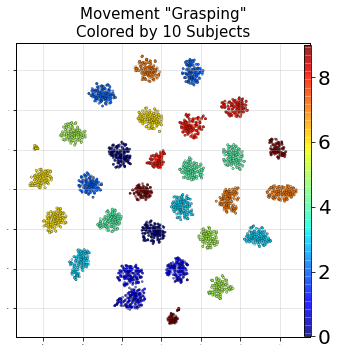

/home/UFAD/hubo/anaconda3/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,


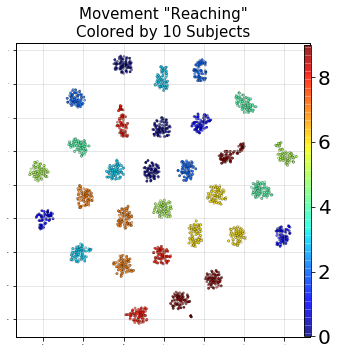

/home/UFAD/hubo/anaconda3/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,


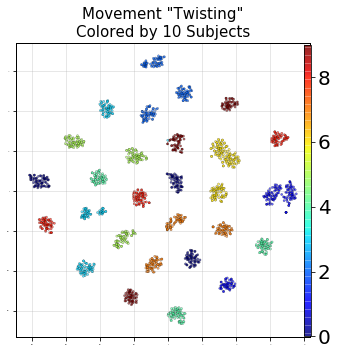

In [146]:
# Show figures for all movements

MOVEMENT_NAME = ['Movement "Grasping"\nColored by 10 Subjects', 'Movement "Reaching"\nColored by 10 Subjects', 'Movement "Twisting"\nColored by 10 Subjects']

for movement in range(0, 3):
    
    save_index = []

    for k in range(0, train_major_label.shape[0]):
        if train_major_label[k] == movement and train_subj_label[k] in [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]:
            save_index.append(k)

    tsne = TSNE(n_components=2, perplexity=10, learning_rate=200, random_state=42)
    X_embedded = tsne.fit_transform(save_train_features[save_index])
    np.save('./x_embedded_movement_{0}.npy'.format(movement), X_embedded)

    fig = plt.figure(figsize=(4.5, 4.5))

    ax_scatter = plt.gca()

    sc = plt.scatter(X_embedded[:, 0], X_embedded[:, 1], marker='o', alpha=.6, label='twist', c=train_subj_label[save_index], s=5, edgecolors='k', linewidths=0.3, cmap='jet')# X_embedded_0 = X_embedded[dot_labels[k] == 0]
    plt.grid('None', alpha=0.3, linewidth=1)
    plt.tick_params(axis='both', which='major', labelsize=0)
    plt.tight_layout()
    plt.title(MOVEMENT_NAME[movement],fontsize=15)

    # plt.colorbar()
    # ax = plt.gca()
    # for spine in ax.spines.values():
    #     spine.set_visible(False)
    ax_cbar = fig.add_axes([.95, 0.06, 0.02, 0.9])  # Syntax: add_axes([left, bottom, width, height])
    cbar = plt.colorbar(sc, cax=ax_cbar)
    cbar.ax.tick_params(labelsize=20)

    for spine in ax_scatter.spines.values():
        spine.set_linewidth(1)  
    # plt.title('Patient Indexes')
#     plt.savefig('./all_cluster/movement_{0}.png'.format(movement), dpi=500, bbox_inches='tight', pad_inches=0.1)
    plt.show()